### Description

- In this assignment, I developed a regression model that predicts the number of bikes shared from a Seoul Bike Sharing program.
- The data used is subset of `Seoul Bike Sharing Demand Data Set` in UCI repository sampled by instructor.
- It comprised of 13 features and ranges from `1/12/2017` to `30/11/2018`.
- The final metric used was `r-squared` score.
- I recieved `0.93150` for a public and `0.94145` for a private leaderboard using XGBoost model after fine-tuning the parameters.
- Website: https://www.kaggle.com/competitions/csci-5622-ps4-22-fall/overview

### Importing Library

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

### EDA

In [13]:
# Reading csv files
XTrain_eda = pd.read_csv('XTrain.csv').rename(columns={'Temperature(�C)': 'T', 'Humidity(%)': 'H'
                                                  , 'Wind speed (m/s)':'WS', 'Visibility (10m)':'V'
                                                  , 'Dew point temperature(�C)': 'DP', 'Solar Radiation (MJ/m2)': 'SR'
                                                  , 'Rainfall(mm)': 'R', 'Snowfall (cm)': 'S'
                                                  , 'Functioning Day': 'FD'})
yTrain_eda = pd.read_csv('yTrain.csv')
XTest_eda = pd.read_csv('XTest.csv').rename(columns={'Temperature(�C)': 'T', 'Humidity(%)': 'H'
                                                  , 'Wind speed (m/s)':'WS', 'Visibility (10m)':'V'
                                                  , 'Dew point temperature(�C)': 'DP', 'Solar Radiation (MJ/m2)': 'SR'
                                                  , 'Rainfall(mm)': 'R', 'Snowfall (cm)': 'S'
                                                  , 'Functioning Day': 'FD'})

In [14]:
XTrain_eda.head()

,Index,Date,Hour,T,H,WS,V,DP,SR,R,S,Seasons,Holiday,FD
0,0,26/04/2018,5,10.2,73,0.8,1137,5.5,0.00,0.0,0.0,Spring,No Holiday,Yes
1,1,2/4/2018,7,15.1,80,1.0,623,11.6,0.01,0.0,0.0,Spring,No Holiday,Yes
2,2,25/05/2018,8,17.1,57,1.7,792,8.5,1.21,0.0,0.0,Spring,No Holiday,Yes
3,3,8/4/2018,22,2.7,88,2.0,621,0.9,0.00,0.0,0.0,Spring,No Holiday,Yes
4,4,6/4/2018,17,6.3,50,4.4,707,-3.3,0.64,0.0,0.0,Spring,No Holiday,Yes


In [15]:
# Handling Date column by chaning it from string to date type
# Used apply/lambda function to handle various date format 
XTrain_eda['Date'] = XTrain_eda['Date'].apply(lambda x: datetime.datetime(int(x.split('/')[2])
                                                                          , int(x.split('/')[1])
                                                                          , int(x.split('/')[0])))
XTest_eda['Date'] = XTest_eda['Date'].apply(lambda x: datetime.datetime(int(x.split('/')[2])
                                                                        , int(x.split('/')[1])
                                                                        , int(x.split('/')[0])))

# Merging XTrain and yTrain data for EDA purpose
Train_eda = pd.merge(XTrain_eda, yTrain_eda, on='Index')
Train_eda = Train_eda.loc[:, Train_eda.columns!='Index']
Test_eda = XTest_eda.loc[:, XTest_eda.columns!='Index']

# Segmenting Date type column into various granuality
# Later, it turned out that seasonality is one of the most important feature for predicting the demands
Train_eda['Day'] = pd.DatetimeIndex(Train_eda['Date']).day
Train_eda['Month'] = pd.DatetimeIndex(Train_eda['Date']).month
Train_eda['Weekday'] = pd.DatetimeIndex(Train_eda['Date']).dayofweek
Test_eda['Day'] = pd.DatetimeIndex(Test_eda['Date']).day
Test_eda['Month'] = pd.DatetimeIndex(Test_eda['Date']).month
Test_eda['Weekday'] = pd.DatetimeIndex(Test_eda['Date']).dayofweek

# Getting rid of the original date type column
Train_eda = Train_eda.loc[:, Train_eda.columns!='Date']
Test_eda = Test_eda.loc[:, Test_eda.columns!='Date']

In [16]:
Train_eda.head()

,Hour,T,H,WS,V,DP,SR,R,S,Seasons,Holiday,FD,Rented Bike Count,Day,Month,Weekday
0,5,10.2,73,0.8,1137,5.5,0.00,0.0,0.0,Spring,No Holiday,Yes,180,26,4,3
1,7,15.1,80,1.0,623,11.6,0.01,0.0,0.0,Spring,No Holiday,Yes,918,2,4,0
2,8,17.1,57,1.7,792,8.5,1.21,0.0,0.0,Spring,No Holiday,Yes,1996,25,5,4
3,22,2.7,88,2.0,621,0.9,0.00,0.0,0.0,Spring,No Holiday,Yes,177,8,4,6
4,17,6.3,50,4.4,707,-3.3,0.64,0.0,0.0,Spring,No Holiday,Yes,776,6,4,4


#### Checking each column
- Determined the preprocessing/transforming method by analyzing a histogram and a line plot.

In [20]:
# Basic statistics of each column
Train_eda.describe().T

,count,mean,std,min,25%,50%,75%,max
Hour,6132.0,11.520059,6.922062,0.0,5.0,12.00,17.00,23.00
T,6132.0,13.002658,11.921261,-17.5,3.5,13.90,22.70,39.30
H,6132.0,58.096053,20.384153,0.0,42.0,57.00,74.00,98.00
WS,6132.0,1.729958,1.045960,0.0,0.9,1.50,2.40,7.30
V,6132.0,1440.791422,606.076776,27.0,946.0,1706.50,2000.00,2000.00
DP,6132.0,4.141813,13.047188,-30.5,-4.7,5.10,14.90,26.80
SR,6132.0,0.578255,0.874270,0.0,0.0,0.01,0.96,3.52
R,6132.0,0.158040,1.227656,0.0,0.0,0.00,0.00,35.00
S,6132.0,0.071836,0.431092,0.0,0.0,0.00,0.00,8.80
Rented Bike Count,6132.0,713.454664,644.588600,0.0,195.0,521.50,1080.00,3556.00


#### Column: Hour

<AxesSubplot:xlabel='Hour', ylabel='Count'>

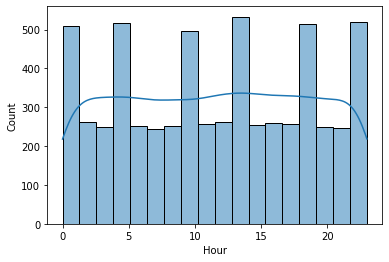

In [21]:
# Hitogram of Column 'Hour'
sns.histplot(Train_eda['Hour'], kde=True)

<AxesSubplot:xlabel='Hour', ylabel='Rented Bike Count'>

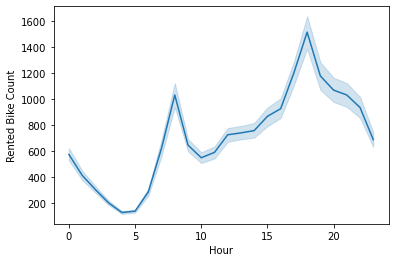

In [22]:
# Line plot of Column 'Hour'
sns.lineplot(data=Train_eda, x="Hour", y="Rented Bike Count")

- Based on the hitogram, the data is pretty well distributed across the day
- Based on the line plot, the number of rented bikes is highly related to the hour of the day
- Instead of using the original data, I encoded the average number of rented bike for each hourly bin

In [23]:
# Encoding the average number of rented bike for each hourly bin
hour_avg = Train_eda[['Hour', 'Rented Bike Count']].groupby('Hour').mean().rename(columns={'Rented Bike Count': 'hour_avg'})
Train_eda['Hour'] = pd.merge(Train_eda, hour_avg, on='Hour', how='left')['hour_avg']
Test_eda['Hour'] = pd.merge(Test_eda, hour_avg, on='Hour', how='left')['hour_avg']

#### Column: Temperature

<AxesSubplot:xlabel='T', ylabel='Count'>

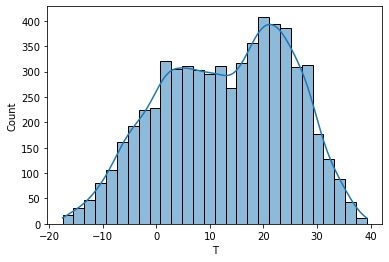

In [25]:
# Hitogram of Column 'T'
sns.histplot(Train_eda['T'], kde=True)

<AxesSubplot:xlabel='T', ylabel='Rented Bike Count'>

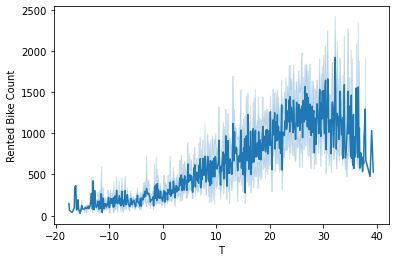

In [27]:
# Line plot of Column 'T'
sns.lineplot(data=Train_eda, x="T", y="Rented Bike Count")

<AxesSubplot:xlabel='T', ylabel='Rented Bike Count'>

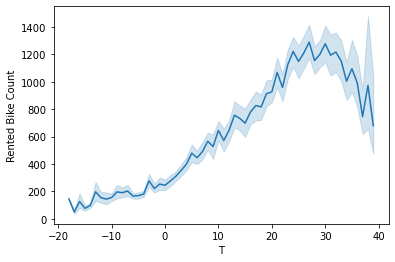

In [30]:
# Line plot of Column 'T' after applying rounding by 1 degree celsius
tmp = Train_eda[['T', 'Rented Bike Count']]
tmp['T'] = round(tmp['T'])
sns.lineplot(data=tmp, x="T", y="Rented Bike Count")

<AxesSubplot:xlabel='T', ylabel='Rented Bike Count'>

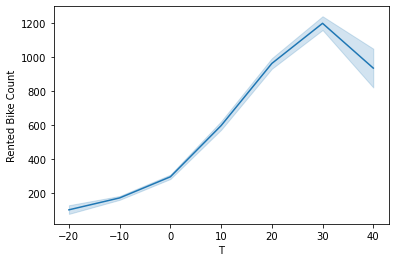

In [31]:
# Line plot of Column 'T' after applying rounding by 10 degree celsius
tmp = Train_eda[['T', 'Rented Bike Count']]
tmp['T'] = round(tmp['T'], -1)
sns.lineplot(data=tmp, x="T", y="Rented Bike Count")

- Based on the histogram, the data is distributed over temperature from -20 to 40 that looks like a bimodal distribution
- Based on the line plot, there seems to be a strong relationship between temperature and the number of bike rented but the variance is high
- So, I applied two types of rounding methods to make variance small and make the prediction more accurate
- When building a model, I tried both rounding methods and chose the first one (i.e. rounding by 1 degree celsius) that showed a better performance on a validation set

In [33]:
# Rounding by 1 degree celsius
Train_eda['T'] = round(Train_eda['T'])
Test_eda['T'] = round(Test_eda['T'])

#### Column: Humidity

<AxesSubplot:xlabel='H', ylabel='Count'>

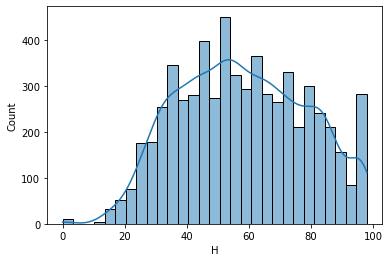

In [34]:
# Hitogram of Column 'H'
sns.histplot(Train_eda['H'], kde=True)

<AxesSubplot:xlabel='H', ylabel='Rented Bike Count'>

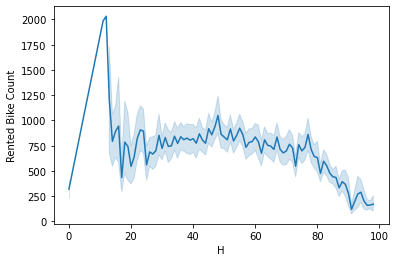

In [35]:
# Line plot of Column 'H'
sns.lineplot(data=Train_eda, x="H", y="Rented Bike Count")

<AxesSubplot:xlabel='H', ylabel='Rented Bike Count'>

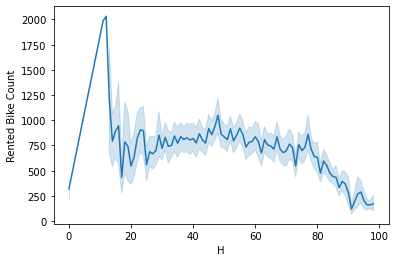

In [38]:
# Line plot of Column 'H' after applying rounding by 1 degree celsius
tmp = Train_eda[['H', 'Rented Bike Count']]
tmp['H'] = round(tmp['H'])
sns.lineplot(data=tmp, x="H", y="Rented Bike Count")

<AxesSubplot:xlabel='H', ylabel='Rented Bike Count'>

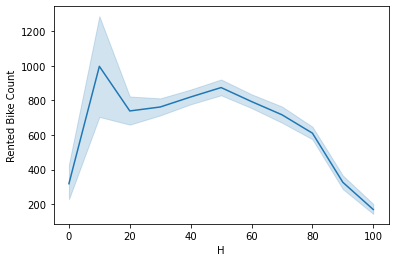

In [39]:
# Line plot of Column 'H' after applying rounding by 10 degree celsius
tmp = Train_eda[['H', 'Rented Bike Count']]
tmp['H'] = round(tmp['H'], -1)
sns.lineplot(data=tmp, x="H", y="Rented Bike Count")

- Based on the histogram, the data is distributed over humidity from 0 to 100 that looks like a unimodal distribution
- Based on the line plot, there seems to be a moderate relationship between humidity and the number of bike rented but the variance is high
- So, I applied two types of rounding methods to make variance small and make the prediction more accurate
- When building a model, I tried both rounding methods and chose the first one (i.e. rounding by 1 degree celsius) that showed a better performance on a validation set

In [40]:
# Rounding by 1 degree celsius
Train_eda['H'] = np.clip(round(Train_eda['H']), a_min=0, a_max=100)
Test_eda['H'] = np.clip(round(Test_eda['H']), a_min=0, a_max=100)

#### Column: Other columns

- I applied similar approach to do EDA on other columns and determined how to preprocess/tranform the original data

<AxesSubplot:>

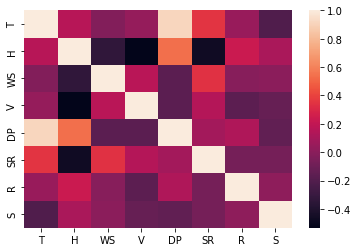

In [55]:
sns.heatmap(XTrain_eda[['T', 'H', 'WS', 'V', 'DP', 'SR', 'R', 'S']].corr())

- In addition, I checked the correlation between columns and decided to remove the column Dew point temperature because it was hight correlated to the column Temperature

### Building a prediction model

#### Importing necessary libraries

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
import datetime
warnings.filterwarnings('ignore')

#### Reading from csv files

In [58]:
XTrain = pd.read_csv('XTrain.csv').rename(columns={'Temperature(�C)': 'T', 'Humidity(%)': 'H'
                                                  , 'Wind speed (m/s)':'WS', 'Visibility (10m)':'V'
                                                  , 'Dew point temperature(�C)': 'DP', 'Solar Radiation (MJ/m2)': 'SR'
                                                  , 'Rainfall(mm)': 'R', 'Snowfall (cm)': 'S'
                                                  , 'Functioning Day': 'FD'})
yTrain = pd.read_csv('yTrain.csv')
XTest = pd.read_csv('XTest.csv').rename(columns={'Temperature(�C)': 'T', 'Humidity(%)': 'H'
                                                  , 'Wind speed (m/s)':'WS', 'Visibility (10m)':'V'
                                                  , 'Dew point temperature(�C)': 'DP', 'Solar Radiation (MJ/m2)': 'SR'
                                                  , 'Rainfall(mm)': 'R', 'Snowfall (cm)': 'S'
                                                  , 'Functioning Day': 'FD'})

#### Preprocessing Data - Rounding/Clipping/Binning data according to the EDA result

In [59]:
# Handling Date column by chaning it from string to date type
# Used apply/lambda function to handle various date format 
XTrain['Date'] = XTrain['Date'].apply(lambda x: datetime.datetime(int(x.split('/')[2]), int(x.split('/')[1]), int(x.split('/')[0])))
XTest['Date'] = XTest['Date'].apply(lambda x: datetime.datetime(int(x.split('/')[2]), int(x.split('/')[1]), int(x.split('/')[0])))

# Removing unnecessary column
Train = XTrain.loc[:, XTrain.columns!='Index']
Test = XTest.loc[:, XTest.columns!='Index']

# Segmenting Date type column into various granuality
Train['Day'] = pd.DatetimeIndex(Train['Date']).day
Train['Month'] = pd.DatetimeIndex(Train['Date']).month
Test['Day'] = pd.DatetimeIndex(Test['Date']).day
Test['Month'] = pd.DatetimeIndex(Test['Date']).month
Train['Weekday'] = pd.DatetimeIndex(Train['Date']).dayofweek
Test['Weekday'] = pd.DatetimeIndex(Test['Date']).dayofweek

# Removing unnecessary column
Train = Train.loc[:, Train.columns!='Date']
Test = Test.loc[:, Test.columns!='Date']

# Rounding column 'T' (Temperature) according to the EDA result
Train['T'] = round(Train['T'])
Test['T'] = round(Test['T'])

# Rounding column 'H' (Humidity) according to the result
Train['H'] = np.clip(round(Train['H']), a_min=0, a_max=100)
Test['H'] = np.clip(round(Test['H']), a_min=0, a_max=100)

# Rounding and clipping column 'WS' (Wind speed) according to the EDA result 
Train['WS'] = np.clip(round(Train['WS']), a_min=0, a_max=6)
Test['WS'] = np.clip(round(Test['WS']), a_min=0, a_max=6)

# Rouding column 'V' (Visibility) according to the EDA result
Train['V'] = round(Train['V'], -2)
Test['V'] = round(Test['V'], -2)

# Rounding column 'DP' (Dew point temperature) according to the EDA result
Train['DP'] = round(Train['DP'])
Test['DP'] = round(Test['DP'])

# Rounding and clipping column 'SR' (Solar Radiation) according to the EDA result
Train['SR'] = np.clip(round(Train['SR']), a_min=0, a_max=4)
Test['SR'] = np.clip(round(Test['SR']), a_min=0, a_max=4)

# Rounding and binning column 'R' (Rainfall) according to the EDA result
Train['R'] = (Train['R']==0).astype('int')
Test['R'] = (Test['R']==0).astype('int')

# Rounding column 'S' (Snowfall) according to the EDA result
Train['S'] = round(Train['S'])
Test['S'] = round(Test['S'])

# Getting rid of samples with 'FD' (Functional Day) eqauls 'False'
# It is based on the obervation that every sample with 'FD'=='False' has zero rented bike
# Samples with 'FD'=='False' will be treated seperately by applying a manual rule (i.e. prediction will be zero when 'FD'=='False')
Train = Train[Train['FD']=='Yes']

#### Preprocessing data - Encoding the original values with average number of rented bikes
- Instead of using one-hot encoding, I encoded the categorical features using the average number of rented bikes to make the prediction more accurate

In [60]:
# Temporary dataframe for calculating the average number of rented bikes according to various categorical features
combined = pd.merge(Train, yTrain, left_index=True, right_index=True)

# Monthly average number of rented bikes 
month_avg =  combined[['Month', 'Rented Bike Count']].groupby('Month').mean().rename(columns={'Rented Bike Count': 'Month_avg'})
# Hourly average number of rented bikes
hour_avg = combined[['Hour', 'Rented Bike Count']].groupby('Hour').mean().rename(columns={'Rented Bike Count': 'hour_avg'})
# Seasonal average number of rented bikes
season_avg = combined[['Seasons', 'Rented Bike Count']].groupby('Seasons').mean().rename(columns={'Rented Bike Count': 'Season_avg'})
# Average number of rented bikes according to weekdays
weekday_avg =  combined[['Weekday', 'Rented Bike Count']].groupby('Weekday').mean().rename(columns={'Rented Bike Count': 'Weekday_avg'})
# Daily average number of rented bikes
daily_avg = combined[['Day', 'Rented Bike Count']].groupby('Day').mean().rename(columns={'Rented Bike Count': 'Daily_avg'})
# Average number of rented bikes according to whether it is a holiday or not
holiday_avg = combined[['Holiday', 'Rented Bike Count']].groupby('Holiday').mean().rename(columns={'Rented Bike Count': 'Holiday_avg'})
# Average number of rented bikes according to whether it is raining or not
R_avg = combined[['R', 'Rented Bike Count']].groupby('R').mean().rename(columns={'Rented Bike Count': 'R_avg'})

# Merging the calculated average values to the original dataframe
Train = pd.merge(Train, month_avg, on='Month', how='left')
Train = pd.merge(Train, hour_avg, on='Hour', how='left')
Train = pd.merge(Train, season_avg, on='Seasons', how='left')
Train = pd.merge(Train, weekday_avg, on='Weekday', how='left')
Train = pd.merge(Train, daily_avg, on='Day', how='left')
Train = pd.merge(Train, holiday_avg, on='Holiday', how='left')
Train = pd.merge(Train, R_avg, on='R', how='left')

Test = pd.merge(Test, month_avg, on='Month', how='left')
Test = pd.merge(Test, hour_avg, on='Hour', how='left')
Test = pd.merge(Test, season_avg, on='Seasons', how='left')
Test = pd.merge(Test, weekday_avg, on='Weekday', how='left')
Test = pd.merge(Test, daily_avg, on='Day', how='left')
Test = pd.merge(Test, holiday_avg, on='Holiday', how='left')
Test = pd.merge(Test, R_avg, on='R', how='left')

# Removing unnecessary columns
X = Train.loc[:, ~Train.columns.isin(['FD', 'Day', 'DP', 'Month', 'Hour', 'Seasons', 'Weekday', 'Day', 'Holiday', 'R'])]
X_test = Test.loc[:, ~Test.columns.isin(['FD', 'Day', 'DP', 'Month', 'Hour', 'Seasons', 'Weekday', 'Day', 'Holiday', 'R'])]

#### Preprocessing - Standardization

In [61]:
# Applying standardization using Scikit-learn's StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_test_scaled = scaler.transform(X_test)

# Getting rid of samples with 'FD' (Functional Day) eqauls 'False'
y = yTrain[XTrain['FD']=='Yes']['Rented Bike Count']

#### Hyperparameter tuning

In [65]:
# I tried various types of machine learning algorithms such as XGBoost, RandomForest, Decision Tree, Polynomial Regression,
# AdaBoost, Deep Neural Networks, and ElasticNet and concluded that XGBoost shows the best performance.
# Fine-tuing XGBRegressor using GridSearchCV
# Carried out several steps to decrease the search spaces
parameters = {'eta': [0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24], 'max_depth': [7]
              , 'reg_lambda': [1.6, 1.7, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4]
              , 'colsample_bytree': [0.76, 0.77, 0.78, 0.79, 0.8, 0.81, 0.82, 0.83, 0.84]}
model = XGBRegressor()
clf = GridSearchCV(model, parameters, scoring='r2', verbose=3)
clf.fit(X_scaled, y)

print(clf.best_score_)
print(clf.best_params_)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
[CV 1/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.925 total time=   0.6s
[CV 2/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.924 total time=   0.5s
[CV 3/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.938 total time=   0.5s
[CV 4/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   0.4s
[CV 5/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   0.4s
[CV 1/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.930 total time=   0.5s
[CV 2/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.924 total time=   0.4s
[CV 3/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, eta=0.16, max_depth=7, reg_lambda=1.7;, scor

[CV 3/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.2;, score=0.937 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.2;, score=0.934 total time=   0.3s
[CV 5/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.2;, score=0.930 total time=   0.3s
[CV 1/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.925 total time=   0.3s
[CV 2/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.925 total time=   0.4s
[CV 3/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.4s
[CV 4/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.936 total time=   0.6s
[CV 5/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.933 total time=   0.5s
[CV 1/5] END colsample_bytree=0.76, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.922 total time=   0.6s
[CV 2/5] END colsample_bytree=0.76, e

[CV 5/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=1.9;, score=0.934 total time=   0.5s
[CV 1/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2;, score=0.924 total time=   0.6s
[CV 2/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2;, score=0.927 total time=   0.9s
[CV 3/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2;, score=0.938 total time=   1.5s
[CV 4/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2;, score=0.939 total time=   0.5s
[CV 5/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2;, score=0.933 total time=   0.4s
[CV 1/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.925 total time=   0.4s
[CV 2/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.5s
[CV 3/5] END colsample_bytree=0.76, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.935 total time=   0.6s
[CV 4/5] END colsample_bytree=0.76, eta=0.19, m

[CV 3/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.7;, score=0.937 total time=   0.6s
[CV 4/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.7;, score=0.935 total time=   0.5s
[CV 5/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.7;, score=0.934 total time=   0.5s
[CV 1/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.926 total time=   0.6s
[CV 2/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.931 total time=   0.6s
[CV 3/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.931 total time=   0.3s
[CV 5/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.931 total time=   0.3s
[CV 1/5] END colsample_bytree=0.76, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.927 total time=   0.3s
[CV 2/5] END colsample_bytree=0.76, e

[CV 5/5] END colsample_bytree=0.76, eta=0.22, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   1.0s
[CV 1/5] END colsample_bytree=0.76, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.927 total time=   0.5s
[CV 2/5] END colsample_bytree=0.76, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.924 total time=   0.3s
[CV 3/5] END colsample_bytree=0.76, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.938 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.935 total time=   0.3s
[CV 5/5] END colsample_bytree=0.76, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.931 total time=   0.3s
[CV 1/5] END colsample_bytree=0.76, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.930 total time=   0.3s
[CV 2/5] END colsample_bytree=0.76, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.926 total time=   0.3s
[CV 3/5] END colsample_bytree=0.76, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, e

[CV 2/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.1;, score=0.925 total time=   0.3s
[CV 3/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.1;, score=0.940 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.1;, score=0.936 total time=   0.3s
[CV 5/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.1;, score=0.932 total time=   0.3s
[CV 1/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.928 total time=   0.3s
[CV 2/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.924 total time=   0.3s
[CV 3/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.941 total time=   0.3s
[CV 4/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.937 total time=   0.3s
[CV 5/5] END colsample_bytree=0.76, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.932 total time=   0.3s
[CV 1/5] END colsample_bytree=0.76, e

[CV 4/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.8;, score=0.940 total time=   0.3s
[CV 5/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.8;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.924 total time=   0.3s
[CV 2/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.928 total time=   0.3s
[CV 3/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.939 total time=   0.4s
[CV 4/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.940 total time=   0.4s
[CV 5/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.935 total time=   0.6s
[CV 1/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=2;, score=0.925 total time=   0.6s
[CV 2/5] END colsample_bytree=0.77, eta=0.17, max_depth=7, reg_lambda=2;, score=0.926 total time=   0.5s
[CV 3/5] END colsample_bytree=0.77, eta=0

[CV 1/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.6;, score=0.922 total time=   0.3s
[CV 2/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.6;, score=0.918 total time=   0.3s
[CV 3/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.6;, score=0.938 total time=   0.3s
[CV 4/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.6;, score=0.938 total time=   0.3s
[CV 5/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.6;, score=0.931 total time=   0.3s
[CV 1/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.926 total time=   0.3s
[CV 2/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.925 total time=   0.3s
[CV 3/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.937 total time=   0.4s
[CV 4/5] END colsample_bytree=0.77, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.940 total time=   0.6s
[CV 5/5] END colsample_bytree=0.77, e

[CV 4/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.5s
[CV 5/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.2;, score=0.933 total time=   0.4s
[CV 1/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.923 total time=   0.3s
[CV 2/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.928 total time=   0.3s
[CV 3/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.931 total time=   0.3s
[CV 4/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.939 total time=   0.4s
[CV 5/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.938 total time=   0.4s
[CV 1/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.925 total time=   0.4s
[CV 2/5] END colsample_bytree=0.77, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.77, eta=0.2, m

[CV 1/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2;, score=0.927 total time=   0.6s
[CV 2/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2;, score=0.928 total time=   0.6s
[CV 3/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2;, score=0.938 total time=   0.5s
[CV 4/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2;, score=0.940 total time=   0.4s
[CV 5/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2;, score=0.933 total time=   0.3s
[CV 1/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.3s
[CV 2/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.929 total time=   0.3s
[CV 3/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.936 total time=   0.3s
[CV 4/5] END colsample_bytree=0.77, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.943 total time=   0.3s
[CV 5/5] END colsample_bytree=0.77, eta=0.22, m

[CV 3/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.7;, score=0.935 total time=   0.5s
[CV 4/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.7;, score=0.939 total time=   0.6s
[CV 5/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.7;, score=0.931 total time=   0.5s
[CV 1/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.921 total time=   0.5s
[CV 2/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.920 total time=   0.3s
[CV 3/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.940 total time=   0.3s
[CV 4/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.945 total time=   0.3s
[CV 5/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.937 total time=   0.3s
[CV 1/5] END colsample_bytree=0.77, eta=0.24, max_depth=7, reg_lambda=1.9;, score=0.923 total time=   0.3s
[CV 2/5] END colsample_bytree=0.77, e

[CV 5/5] END colsample_bytree=0.78, eta=0.16, max_depth=7, reg_lambda=2.3;, score=0.938 total time=   0.3s
[CV 1/5] END colsample_bytree=0.78, eta=0.16, max_depth=7, reg_lambda=2.4;, score=0.924 total time=   0.3s
[CV 2/5] END colsample_bytree=0.78, eta=0.16, max_depth=7, reg_lambda=2.4;, score=0.928 total time=   0.3s
[CV 3/5] END colsample_bytree=0.78, eta=0.16, max_depth=7, reg_lambda=2.4;, score=0.937 total time=   0.5s
[CV 4/5] END colsample_bytree=0.78, eta=0.16, max_depth=7, reg_lambda=2.4;, score=0.937 total time=   0.6s
[CV 5/5] END colsample_bytree=0.78, eta=0.16, max_depth=7, reg_lambda=2.4;, score=0.938 total time=   0.7s
[CV 1/5] END colsample_bytree=0.78, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.927 total time=   0.6s
[CV 2/5] END colsample_bytree=0.78, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.925 total time=   0.5s
[CV 3/5] END colsample_bytree=0.78, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   0.5s
[CV 4/5] END colsample_bytree=0.78, e

[CV 2/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.1;, score=0.936 total time=   0.4s
[CV 4/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.1;, score=0.941 total time=   0.3s
[CV 5/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.1;, score=0.933 total time=   0.3s
[CV 1/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.925 total time=   0.3s
[CV 2/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.926 total time=   0.3s
[CV 3/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.936 total time=   0.3s
[CV 4/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.5s
[CV 5/5] END colsample_bytree=0.78, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.936 total time=   0.6s
[CV 1/5] END colsample_bytree=0.78, e

[CV 4/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.8;, score=0.941 total time=   0.3s
[CV 5/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.8;, score=0.933 total time=   0.3s
[CV 1/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.928 total time=   0.4s
[CV 2/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.929 total time=   0.4s
[CV 3/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.935 total time=   0.3s
[CV 4/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.936 total time=   0.3s
[CV 5/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.933 total time=   0.3s
[CV 1/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=2;, score=0.926 total time=   0.3s
[CV 2/5] END colsample_bytree=0.78, eta=0.2, max_depth=7, reg_lambda=2;, score=0.931 total time=   0.6s
[CV 3/5] END colsample_bytree=0.78, eta=0.2, max_d

[CV 2/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.6;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.6;, score=0.941 total time=   0.4s
[CV 4/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.6;, score=0.936 total time=   0.4s
[CV 5/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.6;, score=0.929 total time=   0.6s
[CV 1/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.921 total time=   0.6s
[CV 2/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.926 total time=   0.6s
[CV 3/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.941 total time=   0.6s
[CV 4/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.937 total time=   0.6s
[CV 5/5] END colsample_bytree=0.78, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.935 total time=   0.5s
[CV 1/5] END colsample_bytree=0.78, e

[CV 4/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.2;, score=0.935 total time=   0.5s
[CV 5/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.2;, score=0.936 total time=   0.4s
[CV 1/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.925 total time=   0.3s
[CV 2/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.928 total time=   0.3s
[CV 3/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.3s
[CV 4/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.942 total time=   0.3s
[CV 5/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.924 total time=   0.3s
[CV 2/5] END colsample_bytree=0.78, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.932 total time=   0.3s
[CV 3/5] END colsample_bytree=0.78, e

[CV 1/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2;, score=0.928 total time=   0.3s
[CV 2/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2;, score=0.931 total time=   0.3s
[CV 3/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2;, score=0.936 total time=   0.3s
[CV 4/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2;, score=0.938 total time=   0.5s
[CV 5/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2;, score=0.939 total time=   0.5s
[CV 1/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.921 total time=   0.6s
[CV 2/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.5s
[CV 3/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.933 total time=   0.4s
[CV 4/5] END colsample_bytree=0.79, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.79, eta=0.16, m

[CV 3/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.7;, score=0.938 total time=   0.4s
[CV 4/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.7;, score=0.942 total time=   0.3s
[CV 5/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.7;, score=0.934 total time=   0.3s
[CV 1/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.927 total time=   0.3s
[CV 2/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.929 total time=   0.3s
[CV 3/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.935 total time=   0.4s
[CV 1/5] END colsample_bytree=0.79, eta=0.18, max_depth=7, reg_lambda=1.9;, score=0.919 total time=   0.6s
[CV 2/5] END colsample_bytree=0.79, e

[CV 5/5] END colsample_bytree=0.79, eta=0.19, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.79, eta=0.19, max_depth=7, reg_lambda=2.4;, score=0.921 total time=   0.3s
[CV 2/5] END colsample_bytree=0.79, eta=0.19, max_depth=7, reg_lambda=2.4;, score=0.928 total time=   0.3s
[CV 3/5] END colsample_bytree=0.79, eta=0.19, max_depth=7, reg_lambda=2.4;, score=0.935 total time=   0.3s
[CV 4/5] END colsample_bytree=0.79, eta=0.19, max_depth=7, reg_lambda=2.4;, score=0.936 total time=   0.3s
[CV 5/5] END colsample_bytree=0.79, eta=0.19, max_depth=7, reg_lambda=2.4;, score=0.932 total time=   0.3s
[CV 1/5] END colsample_bytree=0.79, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.928 total time=   0.3s
[CV 2/5] END colsample_bytree=0.79, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.922 total time=   0.3s
[CV 3/5] END colsample_bytree=0.79, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.79, eta=

[CV 3/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.1;, score=0.939 total time=   0.4s
[CV 4/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.1;, score=0.939 total time=   0.4s
[CV 5/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.1;, score=0.935 total time=   0.4s
[CV 1/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.925 total time=   0.4s
[CV 2/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.926 total time=   0.4s
[CV 3/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.4s
[CV 4/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.4s
[CV 5/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.932 total time=   0.4s
[CV 1/5] END colsample_bytree=0.79, eta=0.21, max_depth=7, reg_lambda=2.3;, score=0.926 total time=   0.4s
[CV 2/5] END colsample_bytree=0.79, e

[CV 5/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=1.8;, score=0.935 total time=   0.4s
[CV 1/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=1.9;, score=0.926 total time=   0.6s
[CV 2/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=1.9;, score=0.927 total time=   0.7s
[CV 3/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=1.9;, score=0.936 total time=   0.5s
[CV 4/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=1.9;, score=0.941 total time=   0.5s
[CV 5/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=1.9;, score=0.934 total time=   0.4s
[CV 1/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=2;, score=0.923 total time=   0.4s
[CV 2/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=2;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.79, eta=0.23, max_depth=7, reg_lambda=2;, score=0.936 total time=   0.4s
[CV 4/5] END colsample_bytree=0.79, eta=0.2

[CV 2/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.925 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.936 total time=   1.4s
[CV 4/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   1.1s
[CV 5/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.6;, score=0.932 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.924 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.928 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.934 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.934 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, eta=0.16, m

[CV 5/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.2;, score=0.931 total time=   0.6s
[CV 1/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.926 total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.925 total time=   0.6s
[CV 3/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.933 total time=   1.2s
[CV 4/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.937 total time=   0.9s
[CV 5/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.932 total time=   0.4s
[CV 1/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.924 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.926 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, eta=0.17, m

[CV 3/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2;, score=0.939 total time=   0.4s
[CV 4/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2;, score=0.937 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2;, score=0.934 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.922 total time=   0.8s
[CV 2/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.8s
[CV 3/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.938 total time=   0.7s
[CV 4/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.941 total time=   0.5s
[CV 5/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.935 total time=   0.5s
[CV 1/5] END colsample_bytree=0.8, eta=0.19, max_depth=7, reg_lambda=2.2;, score=0.925 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, eta=0.19, max_dep

[CV 1/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.925 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.925 total time=   0.5s
[CV 3/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.942 total time=   0.6s
[CV 4/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.940 total time=   0.6s
[CV 5/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.934 total time=   0.5s
[CV 1/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.924 total time=   0.5s
[CV 2/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.924 total time=   0.5s
[CV 3/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.936 total time=   0.5s
[CV 4/5] END colsample_bytree=0.8, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.942 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, eta=0.21, m

[CV 4/5] END colsample_bytree=0.8, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.941 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, eta=0.22, max_depth=7, reg_lambda=2.4;, score=0.935 total time=   0.4s
[CV 1/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.922 total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.936 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.944 total time=   0.3s
[CV 5/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.929 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.7;, score=0.925 total time=   0.3s
[CV 2/5] END colsample_bytree=0.8, eta=0.23, max_depth=7, reg_lambda=1.7;, score=0.923 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, eta=0.23, m

[CV 2/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.924 total time=   0.5s
[CV 3/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.5s
[CV 4/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.942 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   1.3s
[CV 1/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.928 total time=   1.0s
[CV 2/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.927 total time=   0.3s
[CV 3/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.938 total time=   0.3s
[CV 4/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.943 total time=   0.3s
[CV 5/5] END colsample_bytree=0.8, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.8, eta=0.24, m

[CV 4/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.940 total time=   0.3s
[CV 5/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=1.9;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2;, score=0.925 total time=   0.3s
[CV 2/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2;, score=0.926 total time=   0.3s
[CV 3/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2;, score=0.937 total time=   0.3s
[CV 4/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2;, score=0.941 total time=   0.3s
[CV 5/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2.1;, score=0.926 total time=   0.4s
[CV 2/5] END colsample_bytree=0.81, eta=0.17, max_depth=7, reg_lambda=2.1;, score=0.932 total time=   0.6s
[CV 3/5] END colsample_bytree=0.81, eta=0.17, m

[CV 1/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.926 total time=   0.6s
[CV 2/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.925 total time=   0.6s
[CV 3/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.937 total time=   0.5s
[CV 4/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.940 total time=   0.5s
[CV 5/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.7;, score=0.937 total time=   0.4s
[CV 1/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.8;, score=0.926 total time=   0.5s
[CV 2/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.8;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.8;, score=0.940 total time=   0.4s
[CV 4/5] END colsample_bytree=0.81, eta=0.19, max_depth=7, reg_lambda=1.8;, score=0.942 total time=   0.5s
[CV 5/5] END colsample_bytree=0.81, e

[CV 4/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.939 total time=   0.4s
[CV 5/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.3;, score=0.938 total time=   0.3s
[CV 1/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.925 total time=   0.4s
[CV 2/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.927 total time=   0.5s
[CV 3/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.940 total time=   0.5s
[CV 4/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.940 total time=   0.4s
[CV 5/5] END colsample_bytree=0.81, eta=0.2, max_depth=7, reg_lambda=2.4;, score=0.939 total time=   0.5s
[CV 1/5] END colsample_bytree=0.81, eta=0.21, max_depth=7, reg_lambda=1.6;, score=0.926 total time=   0.4s
[CV 2/5] END colsample_bytree=0.81, eta=0.21, max_depth=7, reg_lambda=1.6;, score=0.920 total time=   0.3s
[CV 3/5] END colsample_bytree=0.81, eta=0.21

[CV 1/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.3s
[CV 2/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.929 total time=   0.3s
[CV 3/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.936 total time=   0.3s
[CV 4/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.943 total time=   0.4s
[CV 5/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.1;, score=0.933 total time=   0.3s
[CV 1/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.2;, score=0.927 total time=   0.3s
[CV 2/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.2;, score=0.929 total time=   0.4s
[CV 3/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.2;, score=0.940 total time=   0.5s
[CV 4/5] END colsample_bytree=0.81, eta=0.22, max_depth=7, reg_lambda=2.2;, score=0.940 total time=   0.3s
[CV 5/5] END colsample_bytree=0.81, e

[CV 3/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.940 total time=   0.3s
[CV 4/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.945 total time=   0.3s
[CV 5/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.8;, score=0.937 total time=   0.3s
[CV 1/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.9;, score=0.923 total time=   0.8s
[CV 2/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.9;, score=0.928 total time=   0.9s
[CV 3/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.9;, score=0.938 total time=   0.7s
[CV 4/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.9;, score=0.943 total time=   0.4s
[CV 5/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=1.9;, score=0.934 total time=   0.3s
[CV 1/5] END colsample_bytree=0.81, eta=0.24, max_depth=7, reg_lambda=2;, score=0.928 total time=   0.4s
[CV 2/5] END colsample_bytree=0.81, eta

[CV 5/5] END colsample_bytree=0.82, eta=0.16, max_depth=7, reg_lambda=2.4;, score=0.938 total time=   0.4s
[CV 1/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.927 total time=   0.7s
[CV 2/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.925 total time=   0.6s
[CV 3/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   1.0s
[CV 4/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.939 total time=   0.4s
[CV 5/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.7;, score=0.922 total time=   0.5s
[CV 2/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.7;, score=0.924 total time=   0.6s
[CV 3/5] END colsample_bytree=0.82, eta=0.17, max_depth=7, reg_lambda=1.7;, score=0.938 total time=   0.6s
[CV 4/5] END colsample_bytree=0.82, e

[CV 2/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.926 total time=   0.6s
[CV 3/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.936 total time=   0.7s
[CV 4/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.5s
[CV 5/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.2;, score=0.936 total time=   0.4s
[CV 1/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.3;, score=0.926 total time=   0.7s
[CV 2/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.3;, score=0.929 total time=   0.5s
[CV 3/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.4s
[CV 4/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.3;, score=0.940 total time=   0.4s
[CV 5/5] END colsample_bytree=0.82, eta=0.18, max_depth=7, reg_lambda=2.3;, score=0.934 total time=   0.5s
[CV 1/5] END colsample_bytree=0.82, e

[CV 4/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.936 total time=   0.4s
[CV 5/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=1.9;, score=0.933 total time=   0.4s
[CV 1/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2;, score=0.926 total time=   0.5s
[CV 2/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2;, score=0.931 total time=   0.6s
[CV 3/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2;, score=0.941 total time=   0.6s
[CV 4/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2;, score=0.941 total time=   0.6s
[CV 5/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2;, score=0.936 total time=   0.9s
[CV 1/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2.1;, score=0.926 total time=   0.7s
[CV 2/5] END colsample_bytree=0.82, eta=0.2, max_depth=7, reg_lambda=2.1;, score=0.929 total time=   0.4s
[CV 3/5] END colsample_bytree=0.82, eta=0.2, max_depth=7

[CV 2/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.926 total time=   1.0s
[CV 3/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.941 total time=   0.8s
[CV 4/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.937 total time=   0.8s
[CV 5/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.7;, score=0.935 total time=   0.5s
[CV 1/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.8;, score=0.923 total time=   0.5s
[CV 2/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.8;, score=0.925 total time=   0.4s
[CV 3/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.8;, score=0.938 total time=   0.4s
[CV 4/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.82, eta=0.22, max_depth=7, reg_lambda=1.8;, score=0.934 total time=   0.3s
[CV 1/5] END colsample_bytree=0.82, e

[CV 4/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.942 total time=   0.3s
[CV 5/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.924 total time=   0.5s
[CV 2/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.932 total time=   0.4s
[CV 3/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.935 total time=   0.5s
[CV 4/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.941 total time=   0.4s
[CV 5/5] END colsample_bytree=0.82, eta=0.23, max_depth=7, reg_lambda=2.4;, score=0.937 total time=   0.5s
[CV 1/5] END colsample_bytree=0.82, eta=0.24, max_depth=7, reg_lambda=1.6;, score=0.922 total time=   0.9s
[CV 2/5] END colsample_bytree=0.82, eta=0.24, max_depth=7, reg_lambda=1.6;, score=0.928 total time=   1.3s
[CV 3/5] END colsample_bytree=0.82, e

[CV 1/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.921 total time=   0.5s
[CV 2/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.933 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.1;, score=0.937 total time=   0.3s
[CV 1/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.2;, score=0.923 total time=   0.3s
[CV 2/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.2;, score=0.923 total time=   0.3s
[CV 3/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.2;, score=0.933 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.16, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, e

[CV 3/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.8;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.9;, score=0.919 total time=   0.3s
[CV 2/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.9;, score=0.924 total time=   0.3s
[CV 3/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.9;, score=0.937 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.9;, score=0.943 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=1.9;, score=0.934 total time=   0.3s
[CV 1/5] END colsample_bytree=0.83, eta=0.18, max_depth=7, reg_lambda=2;, score=0.927 total time=   0.3s
[CV 2/5] END colsample_bytree=0.83, eta

[CV 5/5] END colsample_bytree=0.83, eta=0.19, max_depth=7, reg_lambda=2.4;, score=0.932 total time=   0.3s
[CV 1/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.928 total time=   0.3s
[CV 2/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.922 total time=   0.3s
[CV 3/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.941 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.6;, score=0.935 total time=   0.3s
[CV 1/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.7;, score=0.928 total time=   0.3s
[CV 2/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.7;, score=0.925 total time=   0.5s
[CV 3/5] END colsample_bytree=0.83, eta=0.2, max_depth=7, reg_lambda=1.7;, score=0.939 total time=   0.5s
[CV 4/5] END colsample_bytree=0.83, eta=0.2, 

[CV 3/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.2;, score=0.932 total time=   0.4s
[CV 1/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.3;, score=0.926 total time=   0.4s
[CV 2/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.3;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.3;, score=0.938 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.3;, score=0.937 total time=   0.3s
[CV 1/5] END colsample_bytree=0.83, eta=0.21, max_depth=7, reg_lambda=2.4;, score=0.927 total time=   0.4s
[CV 2/5] END colsample_bytree=0.83, e

[CV 5/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=1.9;, score=0.934 total time=   0.4s
[CV 1/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2;, score=0.923 total time=   0.3s
[CV 2/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2;, score=0.927 total time=   0.5s
[CV 3/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2;, score=0.936 total time=   0.3s
[CV 4/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2;, score=0.941 total time=   0.3s
[CV 5/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2;, score=0.932 total time=   0.4s
[CV 1/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2.1;, score=0.924 total time=   1.0s
[CV 2/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2.1;, score=0.929 total time=   0.9s
[CV 3/5] END colsample_bytree=0.83, eta=0.23, max_depth=7, reg_lambda=2.1;, score=0.939 total time=   0.8s
[CV 4/5] END colsample_bytree=0.83, eta=0.23, m

[CV 2/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.928 total time=   0.5s
[CV 3/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.934 total time=   0.6s
[CV 4/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.934 total time=   0.4s
[CV 5/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.7;, score=0.935 total time=   0.4s
[CV 1/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.8;, score=0.925 total time=   0.3s
[CV 2/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.8;, score=0.927 total time=   0.3s
[CV 3/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.8;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.8;, score=0.937 total time=   0.3s
[CV 5/5] END colsample_bytree=0.84, eta=0.16, max_depth=7, reg_lambda=1.8;, score=0.932 total time=   0.3s
[CV 1/5] END colsample_bytree=0.84, e

[CV 4/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.937 total time=   0.7s
[CV 5/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.3;, score=0.932 total time=   1.1s
[CV 1/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.924 total time=   2.2s
[CV 2/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.926 total time=   0.4s
[CV 3/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.939 total time=   0.5s
[CV 4/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.939 total time=   0.4s
[CV 5/5] END colsample_bytree=0.84, eta=0.17, max_depth=7, reg_lambda=2.4;, score=0.934 total time=   0.4s
[CV 1/5] END colsample_bytree=0.84, eta=0.18, max_depth=7, reg_lambda=1.6;, score=0.926 total time=   0.4s
[CV 2/5] END colsample_bytree=0.84, eta=0.18, max_depth=7, reg_lambda=1.6;, score=0.926 total time=   0.4s
[CV 3/5] END colsample_bytree=0.84, e

[CV 1/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.922 total time=   0.3s
[CV 2/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.927 total time=   0.4s
[CV 3/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.938 total time=   0.4s
[CV 4/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.941 total time=   0.6s
[CV 5/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.1;, score=0.935 total time=   0.8s
[CV 1/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.2;, score=0.925 total time=   0.6s
[CV 2/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.2;, score=0.928 total time=   0.5s
[CV 3/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.2;, score=0.935 total time=   0.5s
[CV 4/5] END colsample_bytree=0.84, eta=0.19, max_depth=7, reg_lambda=2.2;, score=0.940 total time=   0.7s
[CV 5/5] END colsample_bytree=0.84, e

[CV 4/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.940 total time=   0.6s
[CV 5/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.8;, score=0.934 total time=   0.6s
[CV 1/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.924 total time=   0.5s
[CV 2/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.924 total time=   0.4s
[CV 3/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.936 total time=   0.4s
[CV 4/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.942 total time=   0.4s
[CV 5/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=1.9;, score=0.933 total time=   0.5s
[CV 1/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=2;, score=0.924 total time=   0.5s
[CV 2/5] END colsample_bytree=0.84, eta=0.21, max_depth=7, reg_lambda=2;, score=0.926 total time=   0.6s
[CV 3/5] END colsample_bytree=0.84, eta=0

[CV 1/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.922 total time=   1.3s
[CV 2/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.927 total time=   1.8s
[CV 3/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.936 total time=   0.9s
[CV 4/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.944 total time=   1.0s
[CV 5/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.6;, score=0.929 total time=   0.5s
[CV 1/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.7;, score=0.925 total time=   0.6s
[CV 2/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.7;, score=0.923 total time=   1.3s
[CV 3/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.7;, score=0.939 total time=   0.6s
[CV 4/5] END colsample_bytree=0.84, eta=0.23, max_depth=7, reg_lambda=1.7;, score=0.936 total time=   0.4s
[CV 5/5] END colsample_bytree=0.84, e

[CV 3/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.3s
[CV 4/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.942 total time=   0.3s
[CV 5/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.2;, score=0.939 total time=   0.3s
[CV 1/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.928 total time=   0.3s
[CV 2/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.927 total time=   0.3s
[CV 3/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.938 total time=   0.3s
[CV 4/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.943 total time=   0.4s
[CV 5/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.3;, score=0.935 total time=   1.6s
[CV 1/5] END colsample_bytree=0.84, eta=0.24, max_depth=7, reg_lambda=2.4;, score=0.927 total time=   1.3s
[CV 2/5] END colsample_bytree=0.84, e

#### Model training & prediction

In [66]:
# Fitting the model with the best parameters
model = XGBRegressor(clf.best_params_)
model.fit(X_scaled, y)

# Make predictions on the test set
# When 'FD'=='No', set the prediction values to zero
# When prediction values are below zero, which is not feasible, set the prediction values to zero
# This can be further improved by ensemble method
Test['prediction'] = model.predict(X_test_scaled)
Test.loc[Test['FD']!='Yes', 'prediction'] = 0
Test.loc[Test['prediction']<0, 'prediction'] = 0

# Making an output csv file
Test['prediction'].reset_index().rename(columns={'index': 'Index', 'prediction':'Rented Bike Count'}).to_csv('fin_prediction.csv', index=False)

XGBoostError: [10:02:41] /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/objective.cc:26: Unknown objective function: `{'colsample_bytree': 0.77, 'eta': 0.2, 'max_depth': 7, 'reg_lambda': 2}`
Objective candidate: survival:aft
Objective candidate: binary:hinge
Objective candidate: multi:softmax
Objective candidate: multi:softprob
Objective candidate: rank:pairwise
Objective candidate: rank:ndcg
Objective candidate: rank:map
Objective candidate: reg:squarederror
Objective candidate: reg:squaredlogerror
Objective candidate: reg:logistic
Objective candidate: binary:logistic
Objective candidate: binary:logitraw
Objective candidate: reg:linear
Objective candidate: reg:pseudohubererror
Objective candidate: count:poisson
Objective candidate: survival:cox
Objective candidate: reg:gamma
Objective candidate: reg:tweedie
Objective candidate: reg:absoluteerror

Stack trace:
  [bt] (0) 1   libxgboost.dylib                    0x00000001178df615 dmlc::LogMessageFatal::~LogMessageFatal() + 117
  [bt] (1) 2   libxgboost.dylib                    0x0000000117a4d2c2 xgboost::ObjFunction::Create(std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > const&, xgboost::GenericParameter const*) + 978
  [bt] (2) 3   libxgboost.dylib                    0x00000001179f08a7 xgboost::LearnerConfiguration::ConfigureObjective(xgboost::LearnerTrainParam const&, std::__1::vector<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > >, std::__1::allocator<std::__1::pair<std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> >, std::__1::basic_string<char, std::__1::char_traits<char>, std::__1::allocator<char> > > > >*) + 1767
  [bt] (3) 4   libxgboost.dylib                    0x00000001179e483d xgboost::LearnerConfiguration::Configure() + 1197
  [bt] (4) 5   libxgboost.dylib                    0x00000001179e4ba9 xgboost::LearnerImpl::UpdateOneIter(int, std::__1::shared_ptr<xgboost::DMatrix>) + 105
  [bt] (5) 6   libxgboost.dylib                    0x00000001178e590f XGBoosterUpdateOneIter + 143
  [bt] (6) 7   libffi.7.dylib                      0x000000010b317ead ffi_call_unix64 + 85
  [bt] (7) 8   ???                                 0x00007ff7b51c5b50 0x0 + 140701872184144

